# Reproducibility Challenge
# Sébastien Pereira et Valentin Noël
# Master DAC
# Apprentissage Statistique

## Introduction

L'objectif de l'article est de fournir un modèle d'apprentissage automatique permettant de générer des dictionnaire d'une langue source vers une langue cible dans un paradigme entièrement non supervisé. 

L'idée principale est de trouver une transformation dans l'espace vectoriel des mots qui aux représentations des mots d'une langue source font correspondre les représentations des mots d'une langue cible. 
Dans cet article nous supposons que nous avons deux espaces vectoriels correspondant à nos deux ensembles de données, source et cible. Ces espaces correspondent aux embbedings monolingues des langues source et cible obtenus de manière indépendante.

L'apprentissage se décompose en deux parties:
- Apprentissage adverse : dans cette partie le but est d'obtenir une première approximation de la transformation de l'espace qui définira notre fonction de mapping de la source vers la cible.
- Analyse procrustéenne :  dans cette partie nous utilisons quelques points particuiers obtenus à l'étape précédente et nous résolvons un problème de Procuste orthogonal, ces étapes sont répétées de manière itérative jusqu'à convergence.

L'inférence s'obtient par la suite grâce à la transformation de l'espace obtenue appliquée aux éléments de la source, puis en utilisant une mesure de similarité CSLS qui permet de résoudre le problème des hubs des KNN (points qui tendent à être les PPV de beaucoup de points en grande dimension -curse of dimensionality).

# Apprentissage adverse

In [1]:
import torch
from torch.nn import Module, Linear, LeakyReLU, LogSoftmax, NLLLoss, ReLU
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [2]:
class Generator(Module):
    def __init__(self, size):
        '''
        :param size: size of the embbeding space transformation
        '''
        super(Generator,self).__init__()
        self.transformation = Linear(size, size)
        
    def forward(self,x):
        '''
        :param x: source word representation vector
        :return: translated word (vector) according to the generator transformation
        '''
        return self.transformation(x)

In [3]:
class Discriminator(Module):
    ''''''
    def __init__(self, dim_in, dim_hid, dim_out):
        '''
        :param dim_in: size of the embbeded space vector
        :param dim_hid: size of the hidden layers
        :param dim_out: output size (being 2 in our problem either source or target)
        '''
        super(Discriminator, self).__init__()
        self.activation1 = LeakyReLU()
        self.activation2 = LeakyReLU()
        self.linear1 = Linear(dim_in, dim_hid)
        self.linear2 = Linear(dim_hid, dim_hid)
        self.linear3 = Linear(dim_hid, dim_out)
        
    def forward(self,x):
        '''
        :param x: input word representation (can be eihter transformed source or target)
        :return : a score vector of size dim_out
        '''
        output = self.activation1(self.linear1(x))
        output = self.activation2(self.linear2(output))
        output = self.linear3(output)
        return output

In [4]:
# Force ortogonality 
def orthogonality(matrix, beta):
    result = (1+beta) * matrix
    result -= beta*(matrix * torch.t(matrix)) * matrix 
    return result

## Données

Nous allons utiliser les word embbedings monolingues déjà disponibles sur les git de facebook
- https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
- https://github.com/facebookresearch/fastText
- https://github.com/facebookresearch/MUSE

In [5]:
import os

source_file = 'data'
fr = 'small.wiki.fr.vec'
en = 'small.wiki.en.vec'
french_path = os.path.join(source_file, fr)
english_path = os.path.join(source_file, en)

french_size = 0
with open(french_path) as fp:
    for idx,line in enumerate(fp):
        french_size +=1
    fp.close()
    print("french_size", french_size)
english_size = 0
with open(english_path) as fp:
    for idx,line in enumerate(fp):
        english_size +=1
    fp.close()
    print("english_size", english_size)



french_size 1000
english_size 1000


In [6]:
with open(french_path) as f:
    for idx, line in enumerate(f):
        if idx < 100:
            print(idx)
            print(line)
        else:
            f.close()
            break

0
1152449 300

1
</s> 0.28556 0.14918 -0.42066 -0.018017 0.22033 -0.014212 -0.22482 -0.14634 -0.2699 0.098651 -0.050317 0.10059 -0.026137 0.37153 0.29702 0.047411 -0.088056 -0.16456 -0.12686 -0.49784 0.038195 0.0413 -0.1882 0.18333 -0.10767 -0.32023 0.29278 -0.23128 -0.21992 -0.32003 -0.03499 0.057215 0.24078 0.26596 -0.22592 0.01992 0.3365 -0.21083 0.26889 0.40077 0.21776 0.22067 0.18016 -0.049212 -0.008983 0.016028 0.11793 -0.35693 -0.069114 0.38563 0.17778 0.31749 -0.42457 -0.056504 0.15986 0.17301 -0.11133 0.49019 -0.087131 -0.3636 -0.1533 -0.084371 -0.091876 -0.37395 -0.023514 0.20364 0.19245 -0.37532 -0.13406 0.063893 -0.1126 -0.046767 -0.1987 0.24293 -0.47214 -0.12061 0.087109 0.40284 0.35148 0.029822 0.022778 0.17187 0.2687 0.10117 0.17393 0.38146 0.065566 0.3744 0.12063 -0.32738 -0.36659 0.25641 -0.18834 -0.035187 -0.17785 -0.13979 0.30206 -0.085775 0.037413 -0.35929 0.38164 0.24672 -0.033128 0.10896 0.080853 -0.16726 0.21757 -0.23939 0.3013 -0.28519 -0.020924 0.2629 -0.23369 

## Apprentissage

In [7]:
import matplotlib.pyplot as plt

print("DEBUT")
emb_space_size = 300

discriminator_hid_size = 2048
output_size = 2

G = Generator(emb_space_size)
D = Discriminator(emb_space_size, discriminator_hid_size, output_size)

m = LogSoftmax()
L = NLLLoss()

d_optimizer = torch.optim.SGD(D.parameters(), lr=0.01, weight_decay=0.95)
g_optimizer = torch.optim.SGD(G.parameters(), lr=0.01, weight_decay=0.95)

num_epochs = 1
nb_batches = 200
    
l_error_g = [] 
l_error_d_real = [] 
l_error_d_fake = [] 
l_error_g_real = []
l_error_global_g = []
l_error_global_d = []

source_file = 'data'
fr = 'small.wiki.fr.vec'
en = 'small.wiki.en.vec'
french_path = os.path.join(source_file, fr)
english_path = os.path.join(source_file, en)
f_source = open(french_path)
f_cible = open(english_path)
entete_source = f_source.readline()
entet_cible = f_cible.readline()

for i in range(0, num_epochs):
    bs = 26 # batch_size
    for j in range(0, nb_batches):
        bs = 1
        batch_X = np.array([f_source.readline().split()[1:]]).astype(np.float)
        batch_y = np.array([f_cible.readline().split()[1:]]).astype(np.float)
        
        ''' 1 Train discriminator on source+target data '''
        D.zero_grad()

        ''' Constructing mini batches '''
        # 1A Train on target data (real data)
        d_real_data = Variable(torch.FloatTensor(batch_y))
        d_real_prediction = D(d_real_data)
        d_real_error = L(m(d_real_prediction), Variable(torch.LongTensor([0]*bs)))
        d_real_error.backward()
        d_optimizer.step()
        l_error_d_real.append(torch.mean(d_real_error.data))

        # 1B Train on source data (fake data)
        d_gen_input = Variable(torch.FloatTensor(batch_X))
        d_fake_data = G(d_gen_input).detach()
        d_fake_prediction = D(d_fake_data)
        d_fake_error = L(m(d_fake_prediction), Variable(torch.LongTensor([1]*bs)))
        d_fake_error.backward()
        d_optimizer.step()
        l_error_d_fake.append(torch.mean(d_fake_error.data))
        
        l_error_global_d.append((l_error_d_fake[-1]+l_error_d_real[-1])/2.0)

        ''' 2 Train generator on D but do not train D here'''
        G.zero_grad()

        gen_input = Variable(torch.FloatTensor(batch_X))
        d_fake_data = G(gen_input)
        dg_fake_prediction = D(d_fake_data)
        g_error = L(m(dg_fake_prediction), Variable(torch.LongTensor([0]*bs)))
        g_error.backward()
        g_optimizer.step()
        l_error_g.append(torch.mean(g_error.data))
        
        d_real_data = Variable(torch.FloatTensor(batch_y))
        dg_real_prediction = D(d_real_data)
        g_error_real = L(m(dg_real_prediction), Variable(torch.LongTensor([1]*bs)))
        l_error_g_real.append(torch.mean(g_error_real.data))
        
        l_error_global_g.append((l_error_g_real[-1]+l_error_g[-1])/2.0)

        # Orthogonality
        G.transformation.weight.data = orthogonality(G.transformation.weight.data, 0.01)
                   
def show(list_err, nom):
    print("Loss "+nom)
    plt.plot(np.arange(0, len(list_err)), list_err)
    plt.show()
    print()


print("FIN")

DEBUT
FIN


Loss error discriminator - GLOBAL


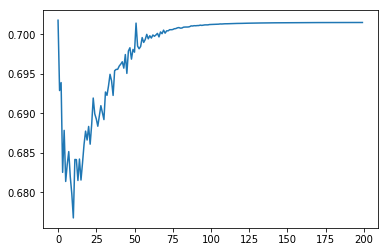


Loss error generator - GLOBAL


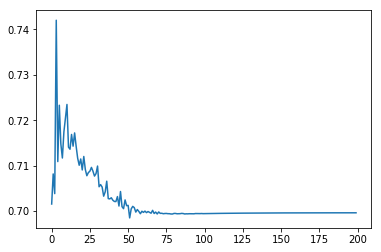

In [8]:
show(l_error_global_d, "error discriminator - GLOBAL")
show(l_error_global_g, "error generator - GLOBAL")

Loss error generator - FAKE


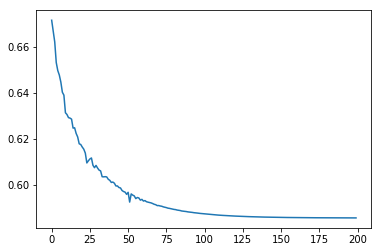


Loss error generator - REAL


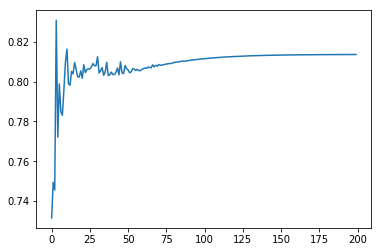


Loss error discriminator - FAKE


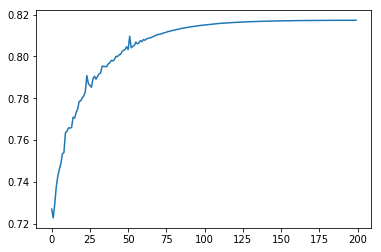


Loss error discriminator - REAL


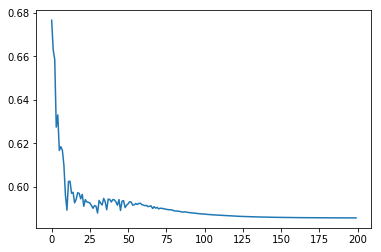

In [9]:
show(l_error_g, "error generator - FAKE")
show(l_error_g_real, "error generator - REAL")
show(l_error_d_fake, "error discriminator - FAKE")
show(l_error_d_real, "error discriminator - REAL")